In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, classification_report, f1_score,accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint as sp_randint


from collections import Counter
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.options.display.float_format = '{:,.6f}'.format

In [2]:
data = pd.read_csv('online_shoppers_intention.csv')
data.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.000000,0,0.000000,2,64.000000,0.000000,0.100000,0.000000,0.000000,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,Feb,4,1,9,3,Returning_Visitor,False,False


In [3]:
data.duplicated().sum()

125

In [4]:
data = data.drop_duplicates()

In [5]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Encoding

In [6]:
data = data.dropna().reset_index(drop=True)

In [7]:
data.Revenue = data.Revenue.astype('int')

In [8]:
#encode weekend
data.Weekend = data.Weekend.astype('int')

from category_encoders import CountEncoder
data = CountEncoder(cols=['OperatingSystems','Browser','Region','VisitorType','Month', 'TrafficType'], normalize=True).fit(data).transform(data)
data.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,0.014830,0.208849,0.198853,0.386235,0.195658,0.854650,0,0
1,0,0.000000,0,0.000000,2,64.000000,0.000000,0.100000,0.000000,0.000000,0.014830,0.535928,0.645883,0.386235,0.320442,0.854650,0,0
2,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,0.014830,0.039164,0.198853,0.041376,0.164932,0.854650,0,0


In [9]:
def my_modeling_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    list_model = [
                LogisticRegression(),
                DecisionTreeClassifier(),
                RandomForestClassifier(random_state = 42),
                xgb.XGBClassifier(random_state = 42)  
    ]

    df = pd.DataFrame(columns = ['Method','F1 Score', 'Classification Report'])

    for model in list_model:
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        method = str(type(model)).split('.')[-1][:-2]

        # AUC Score
        f1  = f1_score(y_test, y_pred)
        c_report = classification_report(y_test, y_pred, digits=6)

        df = df.append({'Method': method,  
                        'F1 Score' : f1,
                        'Classification Report': c_report},
                     ignore_index=True)
    return df

In [10]:
def my_modeling_train(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    list_model = [
                LogisticRegression(),
                DecisionTreeClassifier(),
                RandomForestClassifier(random_state = 42),
                xgb.XGBClassifier(random_state = 42)  
    ]

    df = pd.DataFrame(columns = ['Method','F1 Score', 'Classification Report'])

    for model in list_model:
        model.fit(X_train,y_train)
        y_pred_train = model.predict(X_train)
        method = str(type(model)).split('.')[-1][:-2]

        # AUC Score
        f1  = f1_score(y_train, y_pred_train)
        c_report = classification_report(y_train, y_pred_train, digits=6)

        df = df.append({'Method': method,  
                        'F1 Score' : f1,
                        'Classification Report': c_report},
                     ignore_index=True)
    return df

In [11]:
X = data.drop('Revenue', axis=1)
y = data[['Revenue']]


scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

df_test = my_modeling_test(X_std,y)
df_test['status'] = 'data test'

In [12]:
X = data.drop('Revenue', axis=1)
y = data[['Revenue']]


scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

df_train = my_modeling_train(X_std,y)
df_train['status'] = 'data train'

In [13]:
df_test

,Method,F1 Score,Classification Report,status
0,LogisticRegression,0.494784,precision recall f1-score ...,data test
1,DecisionTreeClassifier,0.572062,precision recall f1-score ...,data test
2,RandomForestClassifier,0.641124,precision recall f1-score ...,data test
3,XGBClassifier,0.659287,precision recall f1-score ...,data test


In [14]:
print(df_test[df_test['Method']=='XGBClassifier']['Classification Report'].values[0])

              precision    recall  f1-score   support

           0   0.932664  0.963119  0.947647      2603
           1   0.736264  0.596882  0.659287       449

    accuracy                       0.909240      3052
   macro avg   0.834464  0.780001  0.803467      3052
weighted avg   0.903770  0.909240  0.905224      3052



In [15]:
df_train

,Method,F1 Score,Classification Report,status
0,LogisticRegression,0.500689,precision recall f1-score ...,data train
1,DecisionTreeClassifier,1.000000,precision recall f1-score ...,data train
2,RandomForestClassifier,1.000000,precision recall f1-score ...,data train
3,XGBClassifier,0.954756,precision recall f1-score ...,data train


In [16]:
print(df_train[df_train['Method']=='XGBClassifier']['Classification Report'].values[0])

              precision    recall  f1-score   support

           0   0.984753  0.998960  0.991806      7694
           1   0.994065  0.918437  0.954756      1459

    accuracy                       0.986125      9153
   macro avg   0.989409  0.958699  0.973281      9153
weighted avg   0.986238  0.986125  0.985900      9153



**seluruh model mengalami overfitting karena peforma data train jauh lebih baik dibandingkan data test**

In [136]:
X = data.drop('Revenue', axis=1)
y = data[['Revenue']]


scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)


In [137]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25, random_state=42)

In [138]:
# model fit
model = xgb.XGBClassifier(random_state = 42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [139]:
params_before = model.get_params()
params_before

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# lakukan SMOTEE untuk semua model
# lakukan hptuning untuk model terbaik

# SMOTEE

In [25]:
# summarize class distribution
print('Before Handling SMOTE',Counter(y_train))

# define undersample strategy
smote = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# summarize class distribution
print('After Handling SMOTE',Counter(y_train_SMOTE))

Before Handling SMOTE Counter({'Revenue': 1})
After Handling SMOTE Counter({'Revenue': 1})


In [27]:
def evaluate(model, x_test = X_test, y_test = y_test, x_train=X_train_SMOTE, y_train=y_train_SMOTE):
    y_pred_train = model.predict(x_train)
    print('======= Data Train =======')
    print('Accuracy Data Train:', accuracy_score(y_train, y_pred_train))
    print('------')
    print('Confusion Matrix Data Train:')
    print()
    print(classification_report(y_train, y_pred_train))
    print('------')
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
    print('Assuming 1 as positive, we get for Data Train:')
    print('')
    print('True Positive:', tp)
    print('True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    print('')
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    print('Precision Data Train:', precision)
    print('Recall Data Train:', recall)
    print('F1-Score Data Train:', 2 * (precision * recall)/(precision + recall))
    
    y_pred = model.predict(x_test)
    print('======= Data Test =======')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('------')
    print('Confusion Matrix Data Test:')
    print()
    print(classification_report(y_test, y_pred))
    print('------')
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Assuming 1 as positive, we get:')
    print('')
    print('True Positive:', tp)
    print('True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    print('')
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    print('Precision Data Test:', precision)
    print('Recall Data Test:', recall)
    print('F1-Score Data Test:', 2 * (precision * recall)/(precision + recall))

# Logistic Regression

In [34]:
lr = LogisticRegression()
lr.fit(X_train_SMOTE, y_train_SMOTE)

LogisticRegression()

In [35]:
evaluate(lr,  x_test = X_test, y_test = y_test, x_train=X_train_SMOTE, y_train=y_train_SMOTE)

======= Data Train =======
Accuracy Data Train: 0.8300623862750195
------
Confusion Matrix Data Train:

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      7694
           1       0.89      0.76      0.82      7694

    accuracy                           0.83     15388
   macro avg       0.84      0.83      0.83     15388
weighted avg       0.84      0.83      0.83     15388

------
Assuming 1 as positive, we get for Data Train:

True Positive: 5835
True Negative: 6938
False Positive: 756
False Negative: 1859

Precision Data Train: 0.8852981338188439
Recall Data Train: 0.7583831557057448
F1-Score Data Train: 0.8169408470423521
======= Data Test =======
Accuracy: 0.8784403669724771
------
Confusion Matrix Data Test:

              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2603
           1       0.57      0.73      0.64       449

    accuracy                           0.88      3052
   m

# Decision Tree

In [28]:
dt = DecisionTreeClassifier()
dt.fit(X_train_SMOTE,y_train_SMOTE)

DecisionTreeClassifier()

In [33]:
evaluate(dt,  x_test = X_test, y_test = y_test, x_train=X_train_SMOTE, y_train=y_train_SMOTE)

======= Data Train =======
Accuracy Data Train: 1.0
------
Confusion Matrix Data Train:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7694
           1       1.00      1.00      1.00      7694

    accuracy                           1.00     15388
   macro avg       1.00      1.00      1.00     15388
weighted avg       1.00      1.00      1.00     15388

------
Assuming 1 as positive, we get for Data Train:

True Positive: 7694
True Negative: 7694
False Positive: 0
False Negative: 0

Precision Data Train: 1.0
Recall Data Train: 1.0
F1-Score Data Train: 1.0
======= Data Test =======
Accuracy: 0.867300131061599
------
Confusion Matrix Data Test:

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2603
           1       0.54      0.61      0.58       449

    accuracy                           0.87      3052
   macro avg       0.74      0.76      0.75      3052
weighted avg    

# Random Forest

In [36]:
rf = RandomForestClassifier()
rf.fit(X_train_SMOTE,y_train_SMOTE)

RandomForestClassifier()

In [37]:
evaluate(rf,  x_test = X_test, y_test = y_test, x_train=X_train_SMOTE, y_train=y_train_SMOTE)

======= Data Train =======
Accuracy Data Train: 1.0
------
Confusion Matrix Data Train:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7694
           1       1.00      1.00      1.00      7694

    accuracy                           1.00     15388
   macro avg       1.00      1.00      1.00     15388
weighted avg       1.00      1.00      1.00     15388

------
Assuming 1 as positive, we get for Data Train:

True Positive: 7694
True Negative: 7694
False Positive: 0
False Negative: 0

Precision Data Train: 1.0
Recall Data Train: 1.0
F1-Score Data Train: 1.0
======= Data Test =======
Accuracy: 0.8928571428571429
------
Confusion Matrix Data Test:

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2603
           1       0.62      0.68      0.65       449

    accuracy                           0.89      3052
   macro avg       0.78      0.81      0.79      3052
weighted avg   

# XGBOOST

In [38]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_SMOTE, y_train_SMOTE)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [39]:
evaluate(xgb_model, x_test = X_test, y_test = y_test, x_train=X_train_SMOTE, y_train=y_train_SMOTE)

======= Data Train =======
Accuracy Data Train: 0.987977644918118
------
Confusion Matrix Data Train:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7694
           1       0.99      0.98      0.99      7694

    accuracy                           0.99     15388
   macro avg       0.99      0.99      0.99     15388
weighted avg       0.99      0.99      0.99     15388

------
Assuming 1 as positive, we get for Data Train:

True Positive: 7562
True Negative: 7641
False Positive: 53
False Negative: 132

Precision Data Train: 0.9930400525279055
Recall Data Train: 0.9828437743696387
F1-Score Data Train: 0.9879156051995558
======= Data Test =======
Accuracy: 0.9020314547837484
------
Confusion Matrix Data Test:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2603
           1       0.67      0.66      0.66       449

    accuracy                           0.90      3052
   macr

**Handling imbalance data target dengan smote tidak menunjukkan peningkatan performa model**

# Hyperparamter Tuning

Hyperparamter tuning dilakukan hanya pada XGBoost karena memiliki performa yang lebih baik dibandingkan model lainnya, dilakukan hyperparameter tunning untuk mengatasi performa model yang masih overfitting

In [140]:
# paramater dari model awal
params_before

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [141]:
## Hyper Parameter Optimization

param_grid= {
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7, 10 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "subsample"        : [ 0.6, 0.7, 0.8, 0.9, 1.0 ],
  "reg_alpha"       : [0, 0.001, 0.01, 0.1, 1, 10]
    
}

In [142]:
# base model fit
xgb_model = xgb.XGBClassifier(random_state = 42)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [143]:
# Membuat objek StratifiedKFold untuk cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Membuat objek RandomizedSearchCV untuk melakukan hyperparameter tuning
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, cv=cv, scoring='roc_auc', n_iter=10, random_state=42)


In [144]:
# Melakukan hyperparameter tuning
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importan...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   param_distrib

In [145]:
# print out the best paramaters

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'subsample': 1.0, 'reg_alpha': 10, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best Score: 0.9273047461211954


In [146]:
# set best parameter
best_params =  random_search.best_params_

# model fit test
xgb_model_best = xgb.XGBClassifier(**best_params, random_state = 42)
xgb_model_best.fit(X_train, y_train)
y_pred_best_test = xgb_model_best.predict(X_test)

In [147]:
# model fit train
xgb_model_best = xgb.XGBClassifier(**best_params, random_state = 42)
xgb_model_best.fit(X_train, y_train)
y_pred_best_train = xgb_model_best.predict(X_train)

In [148]:
print("Classification Report Data Train:")
print(classification_report(y_train,y_pred_best_train))

Classification Report Data Train:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7694
           1       0.85      0.71      0.77      1459

    accuracy                           0.93      9153
   macro avg       0.90      0.84      0.87      9153
weighted avg       0.93      0.93      0.93      9153



In [149]:
print("Classification Report Data Test:")
print(classification_report(y_test,y_pred_best_test))

Classification Report Data Test:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2603
           1       0.74      0.59      0.66       449

    accuracy                           0.91      3052
   macro avg       0.84      0.78      0.80      3052
weighted avg       0.90      0.91      0.90      3052



In [150]:
cm = confusion_matrix(y_test, y_pred_best_test)
cm

array([[2510,   93],
       [ 184,  265]], dtype=int64)

- True positive : 2510
- False positive : 184
- True negative : 265
- False negative : 93

**Performa model menjadi lebih baik dibandingkan sebelumnya setelah dilakukan hyperparamter tuning**

## ROC - AUC graph

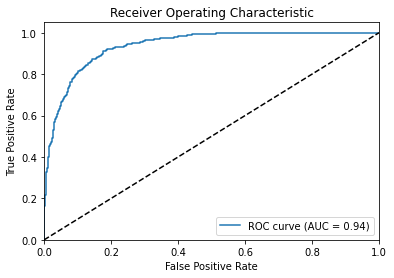

In [165]:
from sklearn.metrics import roc_curve, roc_auc_score

# Memprediksi probabilitas kelas positif
y_pred_proba = xgb_model_best.predict_proba(X_test)[:, 1]  

# Menghitung nilai ROC AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Menghitung false positive rate, true positive rate, dan threshold menggunakan roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


# Menampilkan grafik ROC
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Kurva ROC mendekati sudut kiri atas dengan nilai AUC yang mendekati 1 menunjukkan bahwa model memiliki tingkat pemisahan yang sangat baik anatara kelas positif dan negatif 

## Feature importance

In [151]:
# Mendapatkan feature importance
importance = xgb_model_best.feature_importances_

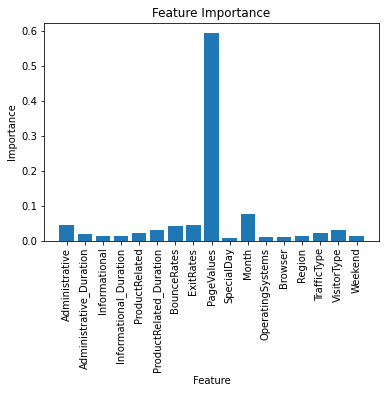

In [153]:
# assign nama features
feature_names = X

# Menampilkan feature importance dalam bentuk grafik
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), feature_names, rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()






Page value memiliki pengaruh yang cukup besar terhadap model dibandingkan fitur lainnya

# Conclusion :

1. Model XgboostClassifier mampu melakukan prediksi dengan f1 score 66% customer (dari 449 customer revenue) yang mampu mengidentifikasi customer yang benar-benar revenue (recall) dan menghindari kesalahan prediksi untuk customer yang sebenanrya tidak revenue (precision)
2. Model XgboosClassifier mampu secara baik membedakan antara customer yang mengalami revenue dan tidak mengalami revenue dengan AUC = 0.94 (mendekati 1)
3. Page Value adalah  fitur yang paling berpengaruh terhadap prediksi model 
